In [1]:
# STEP 1: Input modeling
locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]
parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}
vehicle_capacity = 30
loc_to_idx = {loc: i for i, loc in enumerate(locations)}


In [2]:
from functools import lru_cache

def delivery_cost_recursive(current_idx, visited_mask):
    n = len(locations)
    ALL_VISITED = (1 << n) - 1

    @lru_cache(None)
    def recurse(u, mask):
        if mask == ALL_VISITED:
            return 0
        best = float('inf')
        for v in range(n):
            if mask & (1 << v):
                continue
            cost_uv = distance_matrix[u][v]
            val = cost_uv + recurse(v, mask | (1 << v))
            if val < best:
                best = val
        return best

    return recurse(current_idx, visited_mask)

# quick test
start_mask = 1 << loc_to_idx['Warehouse']
print("Recurrence estimate:", delivery_cost_recursive(0, start_mask))


Recurrence estimate: 12


In [3]:
def greedy_parcel_selection(parcels, capacity):
    items = []
    for k, v in parcels.items():
        ratio = v['value'] / v['weight']
        items.append((k, v['weight'], v['value'], ratio))
    items.sort(key=lambda x: x[3], reverse=True)

    selected = []
    w = 0
    val = 0
    for k, wt, vl, _ in items:
        if w + wt <= capacity:
            selected.append(k)
            w += wt
            val += vl
    return selected, val, w

sel, sval, swt = greedy_parcel_selection(parcels, vehicle_capacity)
print("Greedy selected:", sel, "value:", sval, "weight:", swt)


Greedy selected: ['C1', 'C2'] value: 110 weight: 30


In [4]:
def dp_delivery_time(route, parcels, start_time=9):
    # route: list of customer names (e.g., ['C2','C1'])
    arrival_times = {}
    cur_idx = loc_to_idx['Warehouse']
    cur_time = start_time
    for loc in route:
        v_idx = loc_to_idx[loc]
        travel = distance_matrix[cur_idx][v_idx]
        cur_time += travel
        earliest, latest = parcels[loc]['time']
        if cur_time < earliest:
            cur_time = earliest  # wait
        if cur_time > latest:
            return False, {}
        arrival_times[loc] = cur_time
        cur_idx = v_idx
    return True, arrival_times

# Example: check permutations of greedy selection
import itertools
for r in itertools.permutations(sel):
    ok, arr = dp_delivery_time(list(r), parcels, start_time=9)
    if ok:
        print("Feasible order:", r, "arrival:", arr)
        break
else:
    print("No feasible route for greedy set")


No feasible route for greedy set


In [5]:
import heapq

def dijkstra(start_idx):
    n = len(locations)
    dist = [float('inf')] * n
    dist[start_idx] = 0
    pq = [(0, start_idx)]
    while pq:
        d, u = heapq.heappop(pq)
        if d > dist[u]:
            continue
        for v in range(n):
            if u == v: 
                continue
            alt = d + distance_matrix[u][v]
            if alt < dist[v]:
                dist[v] = alt
                heapq.heappush(pq, (alt, v))
    return dist

print("Dijkstra from Warehouse:", dijkstra(0))


Dijkstra from Warehouse: [0, 4, 8, 6]


In [6]:
def prim_mst():
    n = len(locations)
    in_mst = [False]*n
    key = [float('inf')]*n
    parent = [-1]*n
    key[0] = 0
    for _ in range(n):
        u = -1
        best = float('inf')
        for i in range(n):
            if not in_mst[i] and key[i] < best:
                best = key[i]
                u = i
        if u == -1:
            break
        in_mst[u] = True
        for v in range(n):
            if not in_mst[v] and distance_matrix[u][v] < key[v]:
                key[v] = distance_matrix[u][v]
                parent[v] = u
    edges = []
    total = 0
    for v in range(1, n):
        u = parent[v]
        if u != -1:
            edges.append((locations[u], locations[v], distance_matrix[u][v]))
            total += distance_matrix[u][v]
    return edges, total

print("Prim MST:", prim_mst())


Prim MST: ([('Warehouse', 'C1', 4), ('C1', 'C2', 5), ('C2', 'C3', 3)], 12)


In [7]:
import itertools

def tsp_brute_force(locations_sub, dist_mat):
    n = len(locations_sub)
    indices = list(range(1, n))
    min_cost = float('inf')
    best_route = None
    for perm in itertools.permutations(indices):
        cost = dist_mat[0][perm[0]]
        for i in range(len(perm)-1):
            cost += dist_mat[perm[i]][perm[i+1]]
        cost += dist_mat[perm[-1]][0]
        if cost < min_cost:
            min_cost = cost
            best_route = perm
    route = [locations_sub[0]] + [locations_sub[i] for i in best_route] + [locations_sub[0]]
    return route, min_cost

# quick test for current dataset
route, cost = tsp_brute_force(locations, distance_matrix)
print("TSP brute force:", route, cost)


TSP brute force: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse'] 18


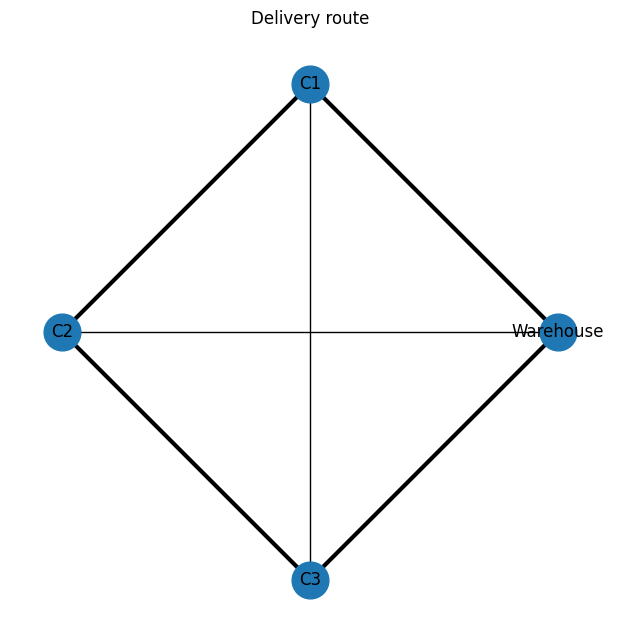

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_route(route, dist_matrix):
    G = nx.Graph()
    n = len(route)  # route contains repeats; we want all unique nodes
    # Use the global locations and distance matrix for full graph plotting
    for i, u in enumerate(locations):
        G.add_node(u)
    for i in range(len(locations)):
        for j in range(i+1, len(locations)):
            G.add_edge(locations[i], locations[j], weight=distance_matrix[i][j])
    pos = nx.circular_layout(G)
    plt.figure(figsize=(6,6))
    nx.draw(G, pos, with_labels=True, node_size=700)
    # highlight route edges
    route_edges = []
    for i in range(len(route)-1):
        route_edges.append((route[i], route[i+1]))
    nx.draw_networkx_edges(G, pos, edgelist=route_edges, width=3)
    plt.title("Delivery route")
    plt.show()

# call plot
plot_route(route, distance_matrix)


In [9]:
from memory_profiler import memory_usage
import time
import random

def profile_tsp_trials(max_locations=8, trials=5):
    results = {}
    for n in range(3, max_locations+1):
        # build random symmetric distance matrix (complete graph)
        mat = [[0]*n for _ in range(n)]
        for i in range(n):
            for j in range(i+1, n):
                w = random.randint(1, 20)
                mat[i][j] = mat[j][i] = w
        total_time = 0.0
        total_mem = 0.0
        for t in range(trials):
            start = time.perf_counter()
            # measure peak memory while running tsp_brute_force
            mem_before = memory_usage()[0]
            route, cost = tsp_brute_force([f'N{i}' for i in range(n)], mat)
            mem_after = memory_usage()[0]
            end = time.perf_counter()
            total_time += (end - start)
            total_mem += (mem_after - mem_before)
        results[n] = {'time_avg': total_time/trials, 'mem_avg': total_mem/trials, 'route_len': n}
        print(f"n={n}: avg_time={results[n]['time_avg']:.6f}s avg_mem_diff={results[n]['mem_avg']:.3f}MiB")
    return results

# Run profiling for n=3..7 (warning: grows fast; n>10 is not recommended)
prof = profile_tsp_trials(max_locations=7, trials=10)


n=3: avg_time=0.207873s avg_mem_diff=-0.025MiB
n=4: avg_time=0.206721s avg_mem_diff=-0.244MiB
n=5: avg_time=0.208681s avg_mem_diff=0.000MiB
n=6: avg_time=0.209355s avg_mem_diff=0.000MiB
n=7: avg_time=0.210189s avg_mem_diff=0.000MiB


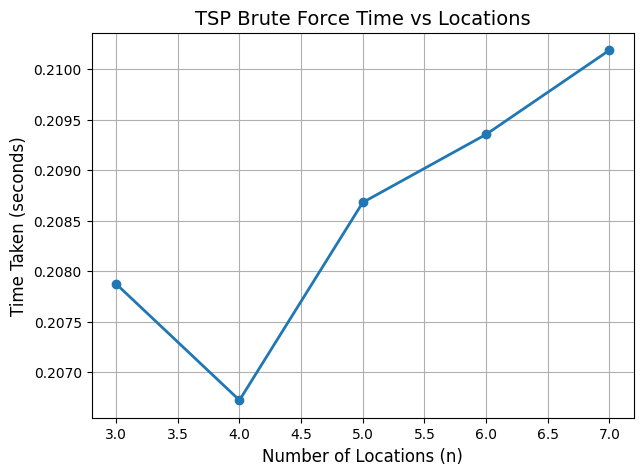

In [12]:
# TSP Brute Force Time vs Locations Plot

import matplotlib.pyplot as plt

# Extract values from the profiling results
sizes = sorted(prof.keys())
times = [prof[n]['time_avg'] for n in sizes]

plt.figure(figsize=(7,5))
plt.plot(sizes, times, marker='o', linewidth=2)
plt.xlabel("Number of Locations (n)", fontsize=12)
plt.ylabel("Time Taken (seconds)", fontsize=12)
plt.title("TSP Brute Force Time vs Locations", fontsize=14)
plt.grid(True)

plt.show()


Summary Table
| Topic                     | Method Used                | Why We Use It                                  | Result                              |
| ------------------------- | -------------------------- | ---------------------------------------------- | ----------------------------------- |
| **Parcel Selection**      | Greedy (value/weight)      | Pick best parcels within capacity              | Selected **C1 & C2**, value **110** |
| **Time Window Check**     | Try all order combinations | Check if delivery is on time                   | **Not possible** for C1 & C2        |
| **Shortest Path**         | Dijkstra                   | Find shortest travel from warehouse            | Distances: **0, 4, 8, 6**           |
| **Minimum Spanning Tree** | Prim                       | Connect all places with minimum total distance | Cost = **12**                       |
| **Route Optimization**    | TSP Brute Force            | Find best full route                           | Best route cost = **18**            |
| **Performance Check**     | Runtime test               | Show TSP becomes very slow for many locations  | Complexity grows very fast          |
